The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


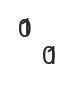

In [29]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)
prime.rename(columns={'Mutant':'Peptide', 'Immunogenicity':'agg_label'},inplace=True)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}
# # train on good ol' Cedar 10-fold dataset
# train_dataset = cedar
# enc_weight_results = {}
# # Good ol' RandomForest
# model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
# trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon,
#                                                             encoding_kwargs=encoding_kwargs, n_jobs=1)

# Check HLA pos-neg ratios & rebalance

## checks

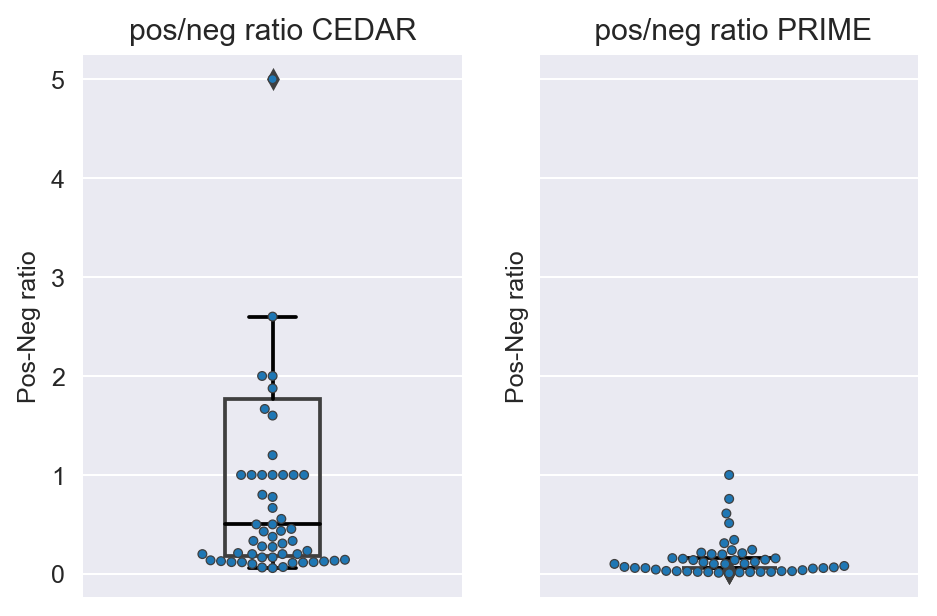

In [32]:
# POS-NEG ratio boxplot
f,a = plt.subplots(1,2, figsize=(6,4), sharey=True)
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[0].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[0].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], size=3.5, linewidth=0.5 )
a[0].set_title('pos/neg ratio CEDAR')
a[0].set_xlabel('')
# PRIME

gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[1].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[1].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], size=3.5, linewidth=0.5 )
a[1].set_title(' pos/neg ratio PRIME')
a[1].set_xlabel('')
pd.options.display.max_rows=10 

Text(0.5, 1.0, 'Pos-Neg ratio vs n_pos per HLA for CEDAR')

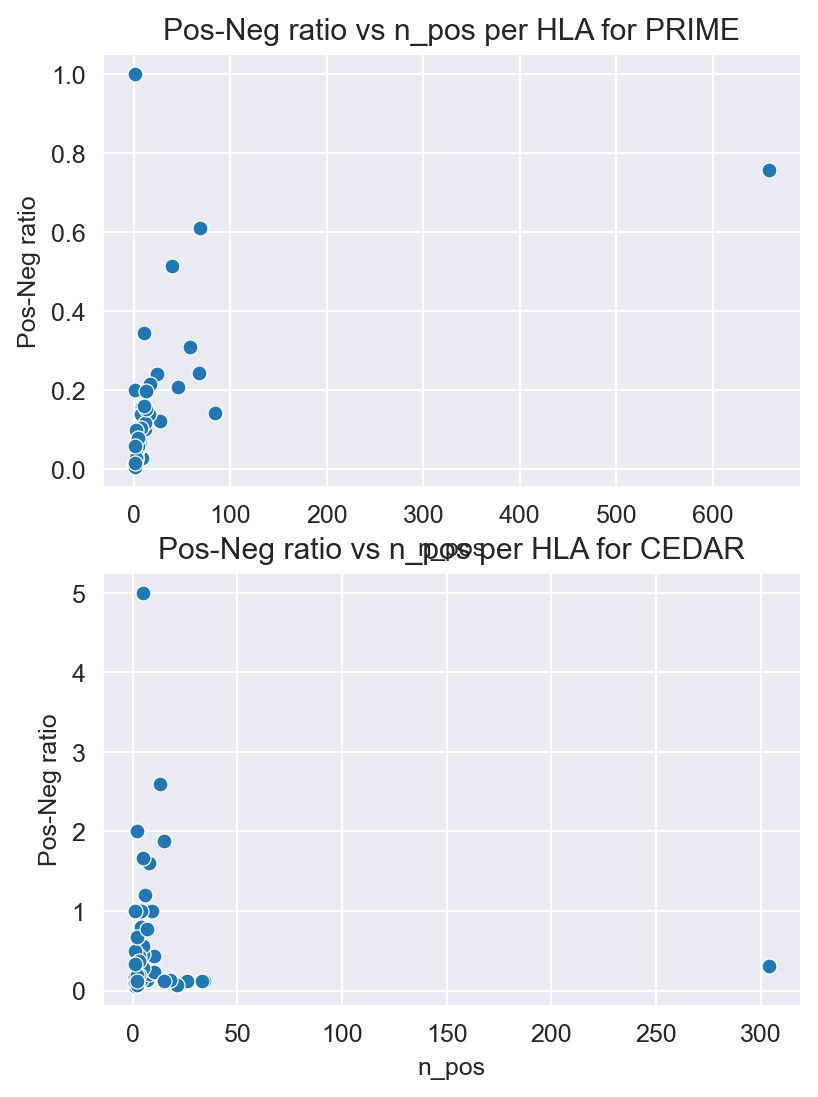

In [34]:
f,a = plt.subplots(2,1, figsize=(5,7))


gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[0])

a[0].set_title('Pos-Neg ratio vs n_pos per HLA for PRIME')


gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)

npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[1])

a[1].set_title('Pos-Neg ratio vs n_pos per HLA for CEDAR')


## rebalance

In [60]:
ref = round(sorted_ratios.loc['HLA-A02:01'].item(), 2)
print(ref)
hla_to_balance = sorted_ratios.query('`Pos-Neg ratio`>=@ref').index
hla_to_balance

0.31


Index(['HLA-A69:01', 'HLA-B44:08', 'HLA-B37:04', 'HLA-C08:02', 'HLA-A02:05',
       'HLA-B39:06', 'HLA-C07:01', 'HLA-A02:11', 'HLA-A02:24', 'HLA-A30:02',
       'HLA-A03:02', 'HLA-C15:02', 'HLA-C07:02', 'HLA-C04:01', 'HLA-B37:01',
       'HLA-B40:01', 'HLA-C03:04', 'HLA-B44:02', 'HLA-A29:02', 'HLA-B13:02',
       'HLA-B54:01', 'HLA-B49:01', 'HLA-C06:02', 'HLA-C14:02', 'HLA-B35:03',
       'HLA-A31:01', 'HLA-A02:03', 'HLA-C03:03', 'HLA-C01:02', 'HLA-B40:02',
       'HLA-A11:02', 'HLA-B52:01', 'HLA-A25:01', 'HLA-A02:06', 'HLA-B51:01',
       'HLA-C05:01', 'HLA-A26:01', 'HLA-C12:02'],
      dtype='object', name='HLA')

In [66]:
for hla in hla_to_balance: 
    tmp=cedar.query('HLA==@hla')
    n_pos = len(tmp.query('agg_label==1'))
    n_neg = len(tmp.query('agg_label==0'))
    if n_neg == 0: 
        

1 0
1 0
1 0
2 0
2 0
1 0
3 0
4 0
1 0
5 0
1 0
5 1
13 5
2 1
2 1
15 8
5 3
8 5
6 5
1 1
1 1
1 1
4 4
1 1
1 1
9 9
4 5
7 9
2 3
5 9
3 6
1 2
5 11
10 23
3 7
3 8
2 6
1 3


For each HLA ; for each peptide: Take same length, ~ rank +/- 5% in order to reach ~0.3 ratio

In [74]:
10/33

0.30303030303030304

In [70]:
cedar.query('HLA=="HLA-A02:01"').groupby('agg_label').count()

,Peptide,HLA,trueHLA_EL_rank,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trainset
agg_label,,,,,,,,,,,,,,,,,,,,,,,,,,
0,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990
1,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304


In [72]:
304/(990+304)

0.23493044822256567